In [1]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

In [2]:
counter = 0
for (test, revealed_targets, sample_prediction) in iter_test:
    sample_prediction['target'] = 0
    env.predict(sample_prediction)
    counter += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


#### TOC
1. Anomalies in Data, and cleaning action & explaination. 15 pts
2. Pairwise Corralation Table and explaition. 10 pts
3. Average records stockID vs Day, 25 pts
    - a. autocorrelation, 10 pts
    - b. measure the distance, 5 pts
    - c. clustering algorithm, 10 pts
4. Closing trajectory of stocks on each day highly correlated, 25 pts
   - a. Make three plots, 10 pts
   - b. permutation test to determine the statistical confidence, 15 pts
      p-value
5. Best prediction model, any approaches, 25 pts
6. submit model on Kaggle, 0 pts

#### Start
- Copy this notebook.
  In Google Colab use `File -> Save a Copy in Drive`.
- Use the "Text" blocks to provide explanations wherever you find them necessary.
- Highlight your answers inside these text fields to ensure that we don't miss it
while grading your HW.

#### Setup

- Code to download the data directly from the colab notebook.
- If you find it easier to download the data from the kaggle website (and
uploading it to your drive), you can skip this section.

In [3]:
!ls '/kaggle/input/optiver-trading-at-the-close'

example_test_files  optiver2023  public_timeseries_testing_util.py  train.csv


#### Q1: Anomalies and Cleaning, 15 pts

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

col_names = [
  "stock_id",
  "date_id",
  "seconds_in_bucket",
  "imbalance_size",
  "imbalance_buy_sell_flag",
  "reference_price",
  "matched_size",
  "far_price",
  "near_price",
  "bid_price",
  "bid_size",
  "ask_price",
  "ask_size",
  "wap",
  "target",
  "time_id",
  "row_id"
]
dtypes = {
  "stock_id": np.int,
  "date_id":np.int,
  "seconds_in_bucket":np.int,
  "imbalance_size":np.float64,
  "imbalance_buy_sell_flag":np.int,
  "reference_price":np.float64,
  "matched_size":np.float64,
  "far_price":np.float64,
  "near_price":np.float64,
  "bid_price":np.float64,
  "bid_size":np.float64,
  "ask_price":np.float64,
  "ask_size":np.float64,
  "wap":np.float64,
  "target":np.float64,
  "time_id":np.int,
  "row_id": "string",
}
df = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/train.csv")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Here, the `df` variable stores the entire dataframe.

In [5]:
df.head(1)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.5,1.000026,8493.03,1.0,-3.029704,0,0_0_0


In [6]:
df.isnull().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

Checking for NULL values. Here, `far_price` and `near_price` are NULL because they aren't reported by the index for `seconds_in_bucket` values less that 240. Moreover, there is a suspicious pattern here - a lot of columns are NULL at exactly 220 places. This might suggest there are a specific set of rows that have all of these fields set to NULL - let's check this.

In [7]:
df[df['wap'].isnull()].head(10)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
369508,131,35,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1925,35_0_131
369700,131,35,10,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1926,35_10_131
369892,131,35,20,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1927,35_20_131
370084,131,35,30,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1928,35_30_131
370276,131,35,40,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1929,35_40_131
370468,131,35,50,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1930,35_50_131
370660,131,35,60,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1931,35_60_131
370852,131,35,70,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1932,35_70_131
371044,131,35,80,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1933,35_80_131
371236,131,35,90,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1934,35_90_131


Our expectations were probably true - it seems to be the case that for a subset of rows, a lot of columns are simulataneously NULL.

In [8]:
df.sort_values(['stock_id', 'date_id', 'time_id'], inplace=True)

Sorting the dataframe by `stock_id`, `date_id` and `time_id` - this would make it convenient for bfill and ffill being used for cleaning later on.

In [9]:
# Function to fill the missing data

def HandleMissingDayData(dataframe, fillType):
    """
    Function to fill missing data with the previous and following day data at same timestamp.

    Parameters:
    fillType (integer): -1 when just removing the rows
                        0 when forward filling using previous day record
                        1 when using mean of previous and following day record

    """
    # imbalance_size, reference_price, matched_size,bid_price, ask_price, wap,
    # far_price, near_price

    nullDataMap = {}
    nullDataFrame = dataframe[dataframe.reference_price.isnull()].copy()
    stockIds = dataframe[dataframe.reference_price.isnull()].stock_id.unique()
    # dateIds = dataframe[dataframe.reference_price.isnull()].date_id.unique()
    for stock_id in stockIds:
        # print(str(stock_id) + ": ")
        # print(nullDataFrame[nullDataFrame['stock_id'] == stock_id].date_id.unique())
        nullDataMap[stock_id] = nullDataFrame[nullDataFrame['stock_id'] == stock_id].date_id.unique()[0]

    if (fillType == 0):
        modifyingColumns = ['imbalance_size', 'matched_size', 'bid_price', 'ask_price', 'bid_size', 'ask_size', 'far_price', 'near_price', 'target', 'reference_price', 'wap']
        for stock_id in nullDataMap.keys():

            maskCurrent = (dataframe['stock_id'] == stock_id) & (dataframe['date_id'] == nullDataMap[stock_id])
            maskPrevious = (dataframe['stock_id'] == stock_id) & (dataframe['date_id'] == nullDataMap[stock_id] - 1) # Doing this directly because there is no null value at date_id = 0
            # maskNext = (dataframe['stock_id'] == stock_id) & (dataframe['date_id'] == nullDataMap[stock_id] + 1) # Doing this directly because there is no null value at date_id = 480
            for timestamp in range(0, 541, 10):
                for column in modifyingColumns:
                #  'far_price', 'near_price' have NaN values upto 300
                    dataframe.loc[maskCurrent & (dataframe['seconds_in_bucket'] == timestamp),
                    column] = dataframe.loc[maskPrevious & (dataframe['seconds_in_bucket'] == timestamp), column].values[0]

    elif (fillType == 1):
        modifyingColumns = ['imbalance_size', 'matched_size', 'bid_price', 'ask_price', 'bid_size', 'ask_size', 'far_price', 'near_price', 'target', 'reference_price', 'wap']
        for stock_id in nullDataMap.keys():
            print(stock_id)
            maskCurrent = (dataframe['stock_id'] == stock_id) & (dataframe['date_id'] == nullDataMap[stock_id])
            maskPrevious = (dataframe['stock_id'] == stock_id) & (dataframe['date_id'] == nullDataMap[stock_id] - 1) # Doing this directly because there is no null value at date_id = 0
            maskNext = (dataframe['stock_id'] == stock_id) & (dataframe['date_id'] == nullDataMap[stock_id] + 1) # Doing this directly because there is no null value at date_id = 480

            for timestamp in range(0, 541, 10):
                for column in modifyingColumns:
                #  'far_price', 'near_price' have NaN values upto 300
                    dataframe.loc[maskCurrent & (dataframe['seconds_in_bucket'] == timestamp),
                    column] = np.mean([dataframe.loc[maskPrevious & (dataframe['seconds_in_bucket'] == timestamp), column].values[0],
                                        dataframe.loc[maskNext & (dataframe['seconds_in_bucket'] == timestamp), column].values[0]])
        if 'wap' in modifyingColumns:
            dataframe['wap'] = dataframe.apply(lambda x: (x['ask_price'] * x['bid_size'] + x['bid_price'] * x['ask_size']) / (x['bid_size'] + x['ask_size']), axis=1)
    return dataframe

In [10]:
df = HandleMissingDayData(df, 1)

19
101
131
158


All the 220 null values are for 4 specific stocks (19, 101, 131, 158) for one day each. To impute them, simple bfill or ffill would not work. Instead, we need to impute for time ti on the null-values day d with the corresponding value at ti on the day d - 1 and / or d + 1 (either bfill, ffill or average of the two), for each stock. 

**The main reason for this averaging is to retain the (expected) autocorrelated nature for each of these variables. Average of next and previous values is more 'curve-friendly' than simple bfill or ffill.**

In [11]:
df.isnull().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                   0
imbalance_buy_sell_flag          0
reference_price                  0
matched_size                     0
far_price                  2894242
near_price                 2857080
bid_price                        0
bid_size                         0
ask_price                        0
ask_size                         0
wap                              0
target                           0
time_id                          0
row_id                           0
dtype: int64

Thus, we have removed all NULL values. The only NULL values that remain are the `far_price` and `near_price`. We will deal with them in the following manner - if `seconds_in_bucket` is ≤ 300, then we imput NULL with 0. Otherwise, we impute it as the average of previous and next values.

In [12]:
seconds_in_bucket_condition = (df['seconds_in_bucket'] <= 300)
far_price_condition = (df['far_price'].isna())
near_price_condition = (df['near_price'].isna())
df.loc[seconds_in_bucket_condition & far_price_condition, 'far_price'] = 0
df.loc[seconds_in_bucket_condition & near_price_condition, 'near_price'] = 0

The `seconds_in_bucket_condition` is used to specify that the setting-NULL-to-0 operation is only being applied to rows with `seconds_in_bucket` <= 300. Further, `far_price_condition` and `near_price_condition` are, respectively, used to mention the application of setting-to-0 operation only to rows where the values of `far_price` and `near_price` are NULL. Otherwise, we would lose out on correct data.

In [13]:
df.isnull().sum()

stock_id                       0
date_id                        0
seconds_in_bucket              0
imbalance_size                 0
imbalance_buy_sell_flag        0
reference_price                0
matched_size                   0
far_price                  32881
near_price                     0
bid_price                      0
bid_size                       0
ask_price                      0
ask_size                       0
wap                            0
target                         0
time_id                        0
row_id                         0
dtype: int64

Even after the earlier imputation, we still find that there are rows where `far_price` is NULL. These rows are the ones where `seconds_in_bucket` is actually > 300 (meaning the values are expected to be present), but they're not. So, we will impute them with the previous value for `far_price`, when the dataframe is sorted according to `stock_id`, `date_id` and `time_id`.

In [14]:
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.0,0.0,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
191,0,0,10,1299772.70,1,1.000026,15261106.63,0.0,0.0,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814,1,0_10_0
382,0,0,20,1299772.70,1,0.999919,15261106.63,0.0,0.0,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009,2,0_20_0
573,0,0,30,1299772.70,1,1.000133,15261106.63,0.0,0.0,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249,3,0_30_0
764,0,0,40,1218204.43,1,1.000455,15342674.90,0.0,0.0,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775,4,0_40_0


In [15]:
df['far_price'] = df['far_price'].fillna(method='ffill')
df.isnull().sum()

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
dtype: int64

There is another issue. Here, there are multiple stocks that do not have data for all the days present. This can be easily verified using the following command:

In [16]:
uniqueRowIDs = set(df['row_id'])
stocksWithMissingDays = set()
for i in range(0, 481):
    for j in range(0, 55):
        for k in range(0, 200):
            rowValue = f'{i}_{j * 10}_{k}'
            if rowValue not in uniqueRowIDs:
                stocksWithMissingDays.add(k)
print(stocksWithMissingDays)

{99, 69, 102, 135, 199, 73, 78, 79, 150, 153, 156}


This cell loops over each `date_id`, for each `time_id`, for each `stock_id` and finds out all the days where data for certain dates is absent. Finding this out is important for Q4, where we transform the dataframe in such a way that each row represents one unique day in the stock market and records the up / down days for every stock. If a stock does not have the data for a given day, it is going to hold NULL values, which is not what we want, especially if we're doing a significance test. 

#### Q2: Pairwise Corralation Table and Explanation. 10 pts

In [17]:
correlation_matrix = df.corr(method='pearson')

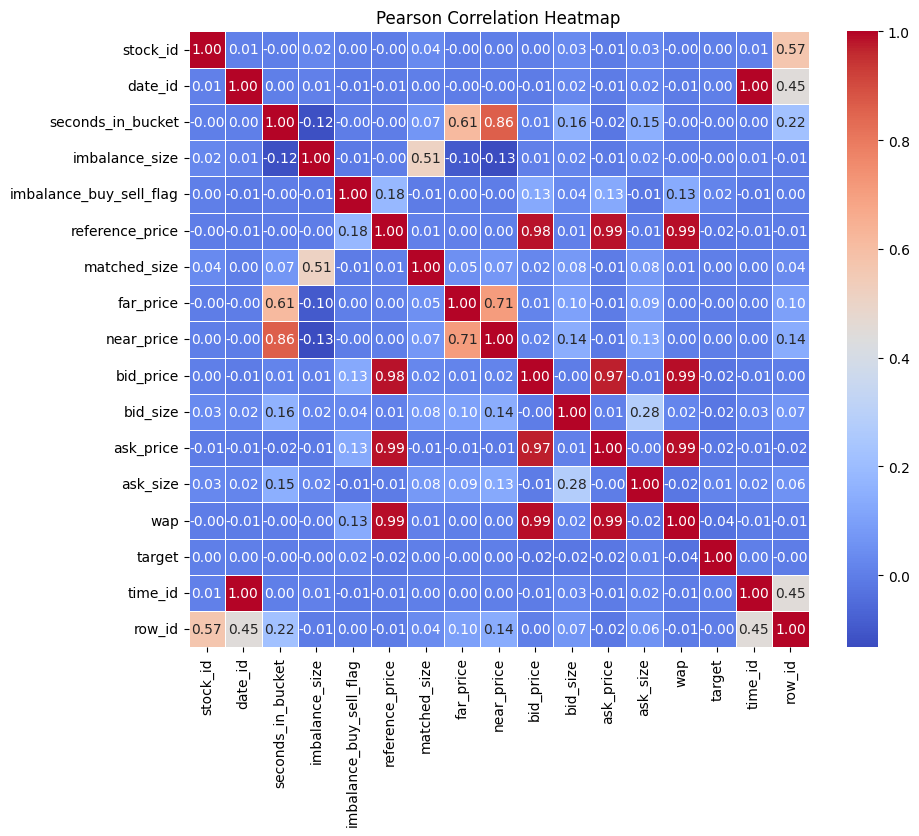

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Pearson Correlation Heatmap')
plt.show()

Reasons for high correlation values:
1. **reference_price** and **bid_price**: a high positive correlation exists between these two columns. It is positive because the bid price for a stock can only be ≥ its reference price. Further, a high absolute value of the correlation might suggest that a bidder is not likely to go much higher than what most people believe is a fair prrice for the stock (which is represented by the reference_price).
2. **wap** and **ask_price**, **wap** and **bid_price**: weighted average price is simply a linear combination of **ask_price** and **bid_price**, given by:
>
> `wap = (bid_price * ask_size + bid_size * ask_price) / (bid_size + ask_size)`
>
As a result of this linear combination, the value of "wap" exhibits a lot of correlation with bid_price and ask_price. Note that if we were using a regression model, it would probably not be wise to include all three of these features at the same time, as regression models require as low multicollinearity between different independent variables as possible so as to obtain a good result, and a high correlation often indicates high multicollinearity.

#### Q3: Average records stockID vs Day, 25 pts
distance function between entries
- a. autocorrelation, 10 pts
- b. measure the distance, 5 pts
- c. clustering algorithm, 10 pts

In [ ]:
csv.describe()

In [ ]:
csv.head(1)

In [ ]:
average_records = csv.groupby(['stock_id', 'date_id']).agg({
    'seconds_in_bucket': 'mean',
    'imbalance_size': 'mean',
    'imbalance_buy_sell_flag': 'mean',
    'reference_price': 'mean',
    'matched_size': 'mean',
    'bid_price': 'mean',
    'bid_size': 'mean',
    'ask_price': 'mean',
    'ask_size': 'mean',
    'wap': 'mean',
    'target': 'mean',
    'time_id': 'count'  # You can change this depending on your needs
}).reset_index()

In [ ]:
average_records.shape

In [ ]:
average_records.head()

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Sort the data by 'stock_id', 'date_id', and 'time_id' in ascending order
csv.sort_values(by=['stock_id', 'date_id', 'time_id'], inplace=True)

# Group data by 'stock_id' and 'date_id' and select the last record for each group
# last_records = csv.groupby(['stock_id', 'date_id']).last().reset_index()

In [ ]:
autocorrelation_results = {}

unique_stock_ids = csv['stock_id'].unique()

for stock_id in unique_stock_ids:
    autocorrelation_results[stock_id] = [[], []]
#     stock_data = last_records[last_records['stock_id'] == stock_id]
#     stock_data = last_records[last_records['stock_id'] == stock_id].copy()
    stock_data = average_records[average_records['stock_id'] == stock_id].copy()
#     max_autocorr = -1
#     optimal_lag = 0
    
    for shift in range(-10, 11):
        if shift != 0:
            temp = stock_data['target'].autocorr(lag=shift)
            autocorrelation_results[stock_id][0].append(shift)
            autocorrelation_results[stock_id][1].append(temp)
#         if temp > max_autocorr:
#             max_autocorr = temp
#             optimal_lag = shift
            
    
    # Calculate the average distance for each day
#     average_distance = stock_data.groupby('date_id')['distance'].mean()

    # Calculate autocorrelation for lags from -10 to 10
#     autocorrelation_results[stock_id] = []

#     for lag in range(-10, 11):
#         autocorr = average_distance.autocorr(lag=lag)
#         autocorrelation_results[stock_id].append((lag, autocorr))

# Perform a hypothesis test for each stock to determine statistical significance
# sig = []
# non_sig = []
# for stock_id, results in autocorrelation_results.items():
#     autocorrelation_df = pd.DataFrame(results, columns=['Lag', 'Autocorrelation'])
#     result = smf.ols('Autocorrelation ~ Lag', data=autocorrelation_df).fit()

#     # Check if the autocorrelation is statistically significant
#     p_value = result.pvalues['Lag']
# #     print(f"p value is {p_value}")
#     alpha = 0.5  # Significance level

#     if abs(p_value) < abs(alpha):
#         sig.append(stock_id)
# #         print(f"Stock {stock_id}: The autocorrelation is statistically significant (p-value < 0.05).")
#     else:
#         non_sig.append(stock_id)
#         print(f"Stock {stock_id}: The autocorrelation is not statistically significant (p-value >= 0.05).")

In [ ]:
csv = csv.sort_values(by=['stock_id', 'date_id', 'time_id'])

# Define the number of days to look back and ahead (10 in this case).
look_back_days = 10
look_ahead_days = 10

# Create an empty DataFrame to store the autocorrelation results.
autocorrelation_results = pd.DataFrame(columns=['stock_id', 'autocorrelation'])

# Group the data by 'stock_id'.
grouped = df.groupby('stock_id')

# Iterate through each group (stock_id).
for stock_id, group in grouped:
    # Calculate autocorrelation for each 'target' value in the group.
    autocorrelations = []
    for i in range(-look_back_days, look_ahead_days + 1):
        autocorrelation = group['target'].autocorr(lag=i)
        autocorrelations.append(autocorrelation)

    # Create a DataFrame for the results and append it to the main results DataFrame.
    stock_autocorr_df = pd.DataFrame({'stock_id': [stock_id] * (2 * look_back_days + 1), 'autocorrelation': autocorrelations})
    autocorrelation_results = autocorrelation_results.append(stock_autocorr_df, ignore_index=True)

# Print or save the autocorrelation results.
print(autocorrelation_results)

In [ ]:
len(autocorrelation_results.keys())

In [ ]:
print(len(sig), len(non_sig))

In [ ]:
len(csv['stock_id'].unique())

In [ ]:
csv.head()

In [ ]:
csv_stockwise = {}
unique_stocks = csv['stock_id'].unique()
for stock in unique_stocks:
    csv_stockwise[stock] = csv[csv['stock_id'] == stock]

In [ ]:
plt.figure(figsize=(11,4), dpi= 80)
pd.plotting.autocorrelation_plot(csv_stockwise[0].loc[:, 'bid_price'])

#### Q4: Closing trajectory of stocks on each day highly correlated, 25 pts
- a. Make three plots, 10 pts
- b. permutation test for statistical confidence, p-value, 15 pts

Here, I have created a new dataframe called q4_df, which contains aggregated values of each row and is grouped by `stock_id` and `date_id`. Note that generally every numerical value is aggregated as **mean**, except for `reference_price`, which is aggregated as product. This is because actually the `reference_price` column is a ratio of the new reference price (in terms of absolute value) to the old reference price (in terms of absolute value), rather than the actual absolute value. Thus, a more accurate estimation of the eventual reference price at the end of the day would be the product of all reference prices and not simply the arithmetic mean. The same is also true for `bid_price`.

In [19]:
q4_df = df.groupby(['stock_id', 'date_id']).agg({
    'seconds_in_bucket': 'mean',
    'imbalance_size': 'mean',
    'imbalance_buy_sell_flag': 'mean',
    'reference_price': 'prod',
    'matched_size': 'mean',
    'bid_price': 'prod',
    'bid_size': 'mean',
    'ask_price': 'prod',
    'ask_size': 'mean',
    'wap': 'mean',
    'target': 'mean',
    'time_id': 'count'  # You can change this depending on your needs
}).reset_index()

In [20]:
q4_df = q4_df[~q4_df['stock_id'].isin(stocksWithMissingDays)]

In [21]:
q4_df.isnull().sum()

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
dtype: int64

In [22]:
perf_df = pd.DataFrame()
q4_df["row_number"] = q4_df.groupby("date_id").cumcount() + 1
perf_df = q4_df.pivot(index='date_id', columns='row_number', values=['reference_price'])
perf_df.columns = [f'stock_{stock_id}' for stock_id in q4_df['stock_id'].unique()]
perf_df.reset_index(inplace=True)

In [23]:
perf_df.head(5)

,date_id,stock_0,stock_1,stock_2,stock_3,stock_4,stock_5,stock_6,stock_7,stock_8,...,stock_189,stock_190,stock_191,stock_192,stock_193,stock_194,stock_195,stock_196,stock_197,stock_198
0,0,0.981676,0.980665,0.975142,0.972667,0.959123,1.066424,1.018245,0.957461,0.937763,...,1.093058,1.070061,1.164560,0.938123,1.003088,0.964803,0.970614,0.976426,0.989290,1.012147
1,1,0.949057,1.013241,1.028246,0.990507,1.083755,1.124239,1.019209,1.062784,1.002415,...,0.982872,0.979526,0.987466,1.035821,1.106003,1.228496,1.002279,0.960323,1.039529,0.997516
2,2,0.943330,0.816405,0.971594,0.993642,0.897965,0.992049,1.006411,1.047231,0.854475,...,0.977736,0.875654,0.982164,1.063471,1.034076,0.983915,0.946070,0.976866,1.054993,0.990386
3,3,0.940381,1.170528,1.051236,0.976517,1.007361,1.023666,0.900020,1.038102,1.010036,...,1.032623,1.064633,1.013655,1.033913,1.047087,1.139446,1.053194,1.017672,1.046020,0.994901
4,4,1.038598,1.072566,1.104198,1.013751,1.122115,0.948031,0.974695,1.099928,1.155052,...,0.975662,0.942585,0.974158,1.058170,1.094019,1.132269,0.930090,0.992498,1.007910,1.022006


In [24]:
for col in perf_df.columns:
    if col != 'date_id':
        perf_df[col] = perf_df[col].apply(lambda x : 1 if x > 1 else -1)

In [25]:
perf_df.head()

,date_id,stock_0,stock_1,stock_2,stock_3,stock_4,stock_5,stock_6,stock_7,stock_8,...,stock_189,stock_190,stock_191,stock_192,stock_193,stock_194,stock_195,stock_196,stock_197,stock_198
0,0,-1,-1,-1,-1,-1,1,1,-1,-1,...,1,1,1,-1,1,-1,-1,-1,-1,1
1,1,-1,1,1,-1,1,1,1,1,1,...,-1,-1,-1,1,1,1,1,-1,1,-1
2,2,-1,-1,-1,-1,-1,-1,1,1,-1,...,-1,-1,-1,1,1,-1,-1,-1,1,-1
3,3,-1,1,1,-1,1,1,-1,1,1,...,1,1,1,1,1,1,1,1,1,-1
4,4,1,1,1,1,1,-1,-1,1,1,...,-1,-1,-1,1,1,1,-1,-1,1,1


In [26]:
columns_to_be_added = [col for col in perf_df.columns]
columns_to_be_added.remove('date_id')
perf_df['total']= perf_df[columns_to_be_added].sum(axis=1)

/tmp/ipykernel_55/2072966057.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  perf_df['total']= perf_df[columns_to_be_added].sum(axis=1)


In [27]:
perf_df.head()

,date_id,stock_0,stock_1,stock_2,stock_3,stock_4,stock_5,stock_6,stock_7,stock_8,...,stock_190,stock_191,stock_192,stock_193,stock_194,stock_195,stock_196,stock_197,stock_198,total
0,0,-1,-1,-1,-1,-1,1,1,-1,-1,...,1,1,-1,1,-1,-1,-1,-1,1,-9
1,1,-1,1,1,-1,1,1,1,1,1,...,-1,-1,1,1,1,1,-1,1,-1,7
2,2,-1,-1,-1,-1,-1,-1,1,1,-1,...,-1,-1,1,1,-1,-1,-1,1,-1,-89
3,3,-1,1,1,-1,1,1,-1,1,1,...,1,1,1,1,1,1,1,1,-1,91
4,4,1,1,1,1,1,-1,-1,1,1,...,-1,-1,1,1,1,-1,-1,1,1,49


In [28]:
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Precision loss occurred in moment calculation due to catastrophic cancellation.")
up_days = []
down_days = []
alpha = 0.05
for date in perf_df['date_id'].unique():
    dist = perf_df[perf_df['date_id'] == date][columns_to_be_added].values.flatten().tolist()
    t_statistic, p_value = stats.ttest_1samp(dist, 0)
    if p_value < alpha / 2:
        if t_statistic >= 0:
            up_days.append(date)
        else:
            down_days.append(date)

In [29]:
print(f"{len(up_days)} up days")
print(f"{len(down_days)} down days")

179 up days
203 down days


## Three plots

### 1. Net stock performance vs. frequency

Text(0, 0.5, 'Frequency')

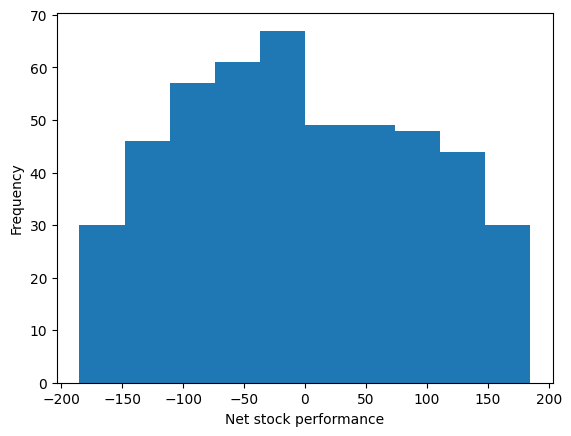

In [30]:
plt.hist(perf_df['total'])
plt.xlabel('Net stock performance')
plt.ylabel('Frequency')

This graph describes the net performance of all stocks for all days vs. frequency. The graph indicates a large volume of days experiencing stocks performing below average in a statistically significant manner. This is backed by our values of number of stocks performing well and number of stocks not performing well, as computed previously.

### 2. Overall market performance during first 100 days to identify the bad days.

<Figure size 640x480 with 0 Axes>

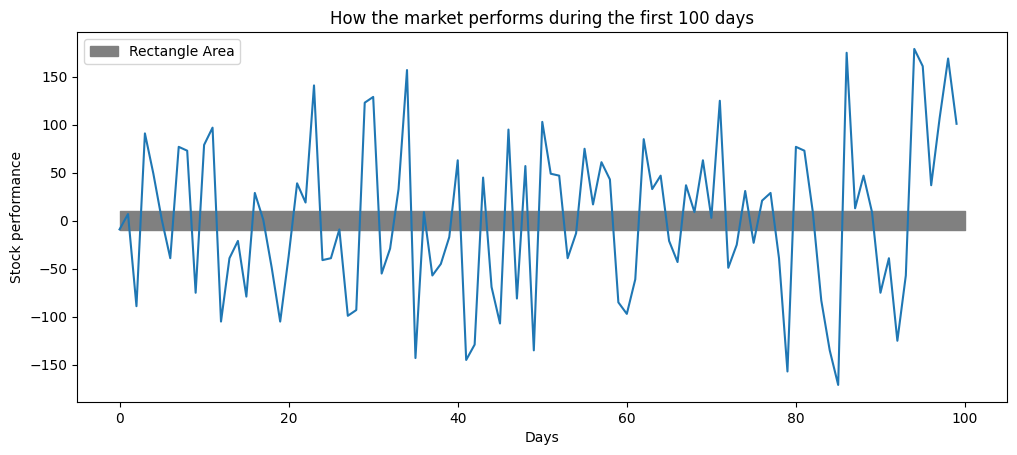

In [32]:
# stock_ids = temp_df['stock_id'].unique()[0 : 50]
days = q4_df['date_id'].unique()[0:100]
y = perf_df['total'][0:100]
plt.figure(figsize=(12, plt.gcf().get_figheight()))
plt.plot(days, y, linestyle='-')
# plt.axhline(y=0, color='r', linestyle='-')
rect_start_x = 0
rect_end_x = 100
rect_bottom = -10
rect_top = 10
plt.fill_between([rect_start_x, rect_end_x], rect_bottom, rect_top, color='gray', alpha=1, label='Rectangle Area')
plt.xlabel('Days')
plt.ylabel('Stock performance')
plt.title('How the market performs during the first 100 days')
plt.legend()
plt.show()

For the first 100 days, the days when the stock market performs the worst (i.e deep troughs) occur at approximately regular intervals of 6 to 8 days, except for when no deep trough occurs between 60 and 80. Note that these deep troughs are only the worst performances for the stock market. There are of course other days between each successive deep troughs where the stock market performs bad in a statistically significant manner, but maybe not to the extent of these regularly occurring deep troughs. Although the visual confirmation may be misleading, one can see that overall in the graph, there are more bad days than good. This sample of the first 100 days displays similar results as the entire population (i.e there are more bad days than good). To approximate statistical significance, I have considered a window of "total" in the range [-10, 10] as being just good or bad 'by chance'.

#### Q5: Best prediction model, any approaches, 25 pts

In [35]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet

# independent_variables = ['imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size', 'bid_size', 'ask_size', 'wap']
independent_variables = ['wap']
dependent_variable = 'target'
model = None
# Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# for stock_id in temp_df['stock_id'].unique():
mae = 0
for stock_id in q4_df['stock_id'].unique():
    stock_df = q4_df[q4_df['stock_id'] == stock_id & ~q4_df[dependent_variable].isnull()]
    X = stock_df[independent_variables]
    y = stock_df[dependent_variable]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = xgb.XGBRegressor( objective='reg:squarederror', max_depth=3, n_estimators=100, learning_rate=0.1)
#     model = DecisionTreeRegressor(max_depth=4)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae += mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 339.6249835414792


#### Q6: submit model on Kaggle, 0 pts
Public Score: \
Private Score: \
Kaggle profile link: \
Screenshot(s):
